# Timing tests from VHS run p2021.1

Some times were estimated from the SXDS field which hass many more exposures so will not be representative of the VHS all SKy data. Here we will reestimate full sky timing estimates from the XMM run to see how processes such as coaddition scale with exposure number.

In [1]:
# What version of the Stack are we using?
! eups list -s | grep lsst_distrib
! eups list -s | grep obs_vista

lsst_distrib          g2d4714e03a+6e1aa0b536 	current w_2022_07 w_latest setup
obs_vista             23.0.0-1   	current setup


In [2]:
import astropy.units as u
from astropy.table import Table
from astropy.time import Time
import numpy as np
import glob
import json

import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
#We are using a rings skymap
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

config = RingsSkyMapConfig()
#These config options are chose to be the same as HSC:
#https://github.com/lsst/obs_subaru/blob/master/config/hsc/makeSkyMap.py
#and copied for obs_vista
#https://github.com/lsst-uk/obs_vista/blob/master/config/makeSkyMap.py
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0/60 # Overlap between tracts (degrees)
config.pixelScale = 0.168
sm = RingsSkyMap(config)
sxds_tracts = [8282,8283,8284,8523,8524,8525,8765,8766,8767] #manually got these from HSC DR2 pages

In [3]:
SUFFIX=time.strftime("%Y%m%d")
WORK_DIR = '/home/ir-shir1/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu4/dmu4_SXDS'
MAKE_INDIVIDUAL_SLURM=True
SLURM_DIR = 'slurm_failed_tiles_rerun_{}'.format(SUFFIX)
print(SUFFIX)

20220316


In [5]:
#USE HSC-Y which is the last task run in the pipeline
#forced = glob.glob('./data/rerun/coaddForcedPhot/deepCoadd-results/HSC-Y/*/*/*.fits)
t = Table.read('../dmu4_VIDEO/slurm/jobs_20220217.lis', format='ascii')

## Times

In [6]:
"I have submitted a total of {} jobs consuming a total of {} cpuhours".format(len(t), np.sum(t['CompHrs']))

'I have submitted a total of 701480 jobs consuming a total of 1225031.9 cpuhours'

In [7]:
t[:5]


JobID,User,Account,JobName,Partition,End,ExitCode,State,CompHrs
str12,str8,str10,str10,str10,str19,str5,str10,float64
25933230,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-13T16:18:36,127:0,FAILED,0.1
25940256,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-14T00:08:41,1:0,FAILED,74.2
25948528,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-14T14:34:59,0:0,COMPLETED,254.3
26005193,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-16T03:59:49,0:0,TIMEOUT,640.0
26027949,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-17T10:46:53,0:0,TIMEOUT,1536.4


In [9]:
" ".join(np.unique(t['JobName']))

'Ex_photop+ Ex_proces+ Example_I+ Mod_photo+ Mod_proce+ SXDS_INGE+ SXDS_Make+ Std_photo+ Std_proce+ VHSMake_c+ VHSTest VHS_INGEST VHS_proce+ VHScoadd VHSmergeT+ VHSphotop+ VHStest VIDEOTest VID_INGEST VIDcoadd VIDphotop+ VIDproces+ VIKINGMak+ VIK_INGEST VIK_SXDS_+ VIK_cut_M+ VIK_test VIKcoadd VIKphotop+ VIKproces+ VIKtestPh+ XMM_INGEST XMM_Make_+ coadd coadd_852+ coadd_arr+ copyHSC cpstack cpujob downHSCDU+ download_+ file_trawl forced_ph+ ingest ingestVHS ingest_al+ phot_8524+ phot_arra+ photopipe photopipe+ processCc+ processCcd rsync_HSC+ runPhotoP+ setup_but+ singlePat+ stackInst+ vidSingFr+ wget_hsc_+ y_test'

In [19]:
t[-5:]


JobID,User,Account,JobName,Partition,End,ExitCode,State,CompHrs
str12,str8,str10,str10,str10,str19,str5,str10,float64
32018844_43+,ir-shir1,iris-ip00+,photopipe,skylake,2020-12-03T19:30:41,1:0,FAILED,0.5
32018844_43+,ir-shir1,iris-ip00+,photopipe,skylake,2020-12-03T19:29:01,1:0,FAILED,0.5
32018844_43+,ir-shir1,iris-ip00+,photopipe,skylake,2020-12-03T19:39:24,1:0,FAILED,0.7
32018844_43+,ir-shir1,iris-ip00+,photopipe,skylake,2020-12-03T20:15:16,1:0,FAILED,1.3
32018844_43+,ir-shir1,iris-ip00+,photopipe,skylake,2020-12-03T19:25:15,2:0,FAILED,0.5


In [22]:
times = Time(t['End'], format='isot', scale='utc')

In [24]:
t['mjd_end'] = times.mjd

In [26]:
t = t[t['mjd_end'] > 59176]

In [14]:

def nameToJobType(name):
    """Take the name and return the tipe of pipetask"""
    job_type = 'UNKNOWN'
    if name.startswith('VHS_proc'):
        job_type = 'processCcd'
    if name.startswith('VHScoadd'):
        job_type = 'coadd'
    if name.startswith('VHSphot'):
        job_type = 'photoPipe'
    return job_type
t['job_type']  = [nameToJobType(n) for n in t['JobName']]

In [16]:
num_processCcd = len(t['CompHrs'][(t['job_type'] == 'processCcd') &(t['State'] == 'COMPLETED') ])
num_coadd= len(t['CompHrs'][(t['job_type'] == 'coadd') &(t['State'] == 'COMPLETED') ])
num_photo = len(t['CompHrs'][(t['job_type'] == 'photoPipe') &(t['State'] == 'COMPLETED') ])

mean_processCcd = np.mean(t['CompHrs'][(t['job_type'] == 'processCcd') &(t['State'] == 'COMPLETED') ])
mean_coadd= np.mean(t['CompHrs'][(t['job_type'] == 'coadd') &(t['State'] == 'COMPLETED') ])
mean_photo = np.mean(t['CompHrs'][(t['job_type'] == 'photoPipe') &(t['State'] == 'COMPLETED') ])

tot_processCcd = np.sum(t['CompHrs'][(t['job_type'] == 'processCcd') &(t['State'] == 'COMPLETED') ])
tot_coadd= np.sum(t['CompHrs'][(t['job_type'] == 'coadd') &(t['State'] == 'COMPLETED') ])
tot_photo = np.sum(t['CompHrs'][(t['job_type'] == 'photoPipe') &(t['State'] == 'COMPLETED') ])

print("""
Full processing of input images: {} cpu hours
Full coadd of all patches: {} cpu hours
Full photometry pipeline on all patches: {} cpu hours
Total time for {} images and {} patch coadss and {} patch photometry pipelines: {} cpu hours
""".format(
    round(mean_processCcd,2),
    round(mean_coadd,2),
    round(mean_photo,2),
    num_processCcd,
    num_coadd,
    num_photo,
    round(
        tot_processCcd 
        + tot_coadd
        + tot_photo,2
    )
))


Full processing of input images: 1.86 cpu hours
Full coadd of all patches: 0.89 cpu hours
Full photometry pipeline on all patches: 2.62 cpu hours
Total time for 12538 images and 35357 patch coadss and 80326 patch photometry pipelines: 265441.7 cpu hours



In [24]:
n_vhs_xmm_images = 2100 # From ../dmu4_XMM/1_Slurm_factory.ipynb - w02_images_job_dict_2100.json
n_vhs_xmm_patches = 3996 #../dmu4_VHS/slurm/w02_patch_job_dict_3996.json

mean_processCcd = np.mean(t['CompHrs'][(t['job_type'] == 'processCcd') &(t['State'] == 'COMPLETED') ])
mean_coadd= np.mean(t['CompHrs'][(t['job_type'] == 'coadd') &(t['State'] == 'COMPLETED') ])
mean_photo = np.mean(t['CompHrs'][(t['job_type'] == 'photoPipe') &(t['State'] == 'COMPLETED') ])

print("""
Full processing of XMM field input images: {} cpu hours
Full coadd of all patches: {} cpu hours
Full photometry pipeline on all patches: {} cpu hours
Total time for {} images and {} patches: {} cpu hours
""".format(
    round(n_vhs_xmm_images * mean_processCcd),
    round(n_vhs_xmm_patches* mean_coadd),
    round(n_vhs_xmm_patches* mean_photo),
    n_vhs_xmm_images, n_vhs_xmm_patches,
    round(
        n_vhs_xmm_images * mean_processCcd 
        + n_vhs_xmm_patches* mean_coadd
        + n_vhs_xmm_patches* mean_photo
    )
))


Full processing of XMM field input images: 3911 cpu hours
Full coadd of all patches: 3570 cpu hours
Full photometry pipeline on all patches: 10472 cpu hours
Total time for 2100 images and 3996 patches: 17953 cpu hours



In [28]:
n_vhs_pdr2_images=7174 #../dmu4_VHS/slurm/full_images_job_dict_7174.json
n_vhs_pdr2_patches=13164 #../dmu4_VHS/slurm/full_patch_job_dict_13164.json

mean_processCcd = np.mean(t['CompHrs'][(t['job_type'] == 'processCcd') &(t['State'] == 'COMPLETED') ])
mean_coadd= np.mean(t['CompHrs'][(t['job_type'] == 'coadd') &(t['State'] == 'COMPLETED') ])
mean_photo = np.mean(t['CompHrs'][(t['job_type'] == 'photoPipe') &(t['State'] == 'COMPLETED') ])

print("""
Full processing of all HSC PDR2/VHS overlap input images: {} cpu hours
Full coadd of all patches: {} cpu hours
Full photometry pipeline on all patches: {} cpu hours
Total time for {} images and {} patches: {} cpu hours
""".format(
    round(n_vhs_pdr2_images * mean_processCcd),
    round(n_vhs_pdr2_patches* mean_coadd),
    round(n_vhs_pdr2_patches* mean_photo),
    n_vhs_pdr2_images, n_vhs_pdr2_patches,
    round(
        n_vhs_pdr2_images * mean_processCcd 
        + n_vhs_pdr2_patches* mean_coadd
        + n_vhs_pdr2_patches* mean_photo
    )
))


Full processing of all HSC PDR2/VHS overlap input images: 13361 cpu hours
Full coadd of all patches: 11760 cpu hours
Full photometry pipeline on all patches: 34498 cpu hours
Total time for 7174 images and 13164 patches: 59619 cpu hours



In [22]:
n_vhs_all_images = 204996 # From ../dmu1/data/vhs_images_overview_$DATE.fits
n_vhs_all_patches =  670137# From ../dmu1/data/vhs_tiles_tracts_patches.fits

mean_processCcd = np.mean(t['CompHrs'][(t['job_type'] == 'processCcd') &(t['State'] == 'COMPLETED') ])
mean_coadd= np.mean(t['CompHrs'][(t['job_type'] == 'coadd') &(t['State'] == 'COMPLETED') ])
mean_photo = np.mean(t['CompHrs'][(t['job_type'] == 'photoPipe') &(t['State'] == 'COMPLETED') ])

print("""
Full processing of input images: {} cpu hours
Full coadd of all patches: {} cpu hours
Full photometry pipeline on all patches: {} cpu hours
Total time for {} images and {} patches: {} cpu hours
""".format(
    round(n_vhs_all_images * mean_processCcd),
    round(n_vhs_all_patches* mean_coadd ), #assume 6 times fewer images to coadd
    round(n_vhs_all_patches* mean_photo ),  #assume JHK and LSST UGRIZY
    n_vhs_all_images, n_vhs_all_patches,
    round(
        n_vhs_all_images * mean_processCcd 
        + n_vhs_all_patches* mean_coadd
        + n_vhs_all_patches* mean_photo
    )
))


Full processing of input images: 381801 cpu hours
Full coadd of all patches: 598648 cpu hours
Full photometry pipeline on all patches: 1756181 cpu hours
Total time for 204996 images and 670137 patches: 2736631 cpu hours



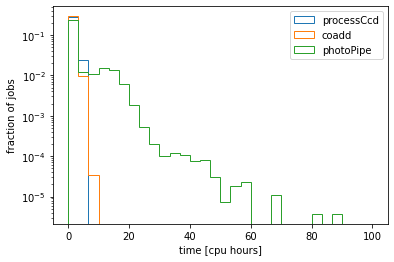

In [29]:
plt.hist(t['CompHrs'][(t['job_type'] == 'processCcd') &(t['State'] == 'COMPLETED')],
         range=[0,100],bins=30,density=True,label='processCcd',histtype='step')
plt.hist(t['CompHrs'][(t['job_type'] == 'coadd') &(t['State'] == 'COMPLETED')],
         range=[0,100],bins=30,density=True,label='coadd',histtype='step')
plt.hist(t['CompHrs'][(t['job_type'] == 'photoPipe') &(t['State'] == 'COMPLETED')],
         range=[0,100],bins=30,density=True,label='photoPipe',histtype='step')
plt.xlabel('time [cpu hours]')
plt.legend()
plt.ylabel('fraction of jobs')
plt.yscale('log')
#plt.ylim((25,250))
plt.savefig('./figs/job_times_hist.pdf', bbox_inches='tight')
plt.savefig('./figs/job_times_hist.png', bbox_inches='tight')